# CVE Growth

In [1]:
# Import necessary libraries
from IPython.core.magic import register_cell_magic
from IPython.display import Markdown
import datetime
from datetime import date
import glob
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from itables import init_notebook_mode, show
import itables.options as opt

# Initialize itables options
opt.dom = "tpir"
opt.style = "table-layout:auto;width:auto"
init_notebook_mode(all_interactive=True, connected=True)

# Register a custom cell magic for markdown
@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))

# Configure logging and warnings
logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")

# Configure pandas display options
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)


In [2]:
def get_nested_value(entry, keys, default='Missing_Data'):
    try:
        for key in keys:
            entry = entry[key]
        return entry
    except (KeyError, IndexError):
        return default

row_accumulator = []
for filename in glob.glob('nvd.jsonl'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data:
            new_row = {
                'CVE': get_nested_value(entry, ['cve', 'id']),
                'Published': get_nested_value(entry, ['cve', 'published']),
                'AttackVector': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'attackVector']),
                'AttackComplexity': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'attackComplexity']),
                'PrivilegesRequired': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'privilegesRequired']),
                'UserInteraction': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'userInteraction']),
                'Scope': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'scope']),
                'ConfidentialityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'confidentialityImpact']),
                'IntegrityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'integrityImpact']),
                'AvailabilityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'availabilityImpact']),
                'BaseScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'baseScore'], '0.0'),
                'BaseSeverity': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'baseSeverity']),
                'ExploitabilityScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'exploitabilityScore']),
                'ImpactScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'impactScore']),
                'CWE': get_nested_value(entry, ['cve', 'weaknesses', 0, 'description', 0, 'value']),
                'Description': get_nested_value(entry, ['cve', 'descriptions', 0, 'value'], ''),
                'Assigner': get_nested_value(entry, ['cve', 'sourceIdentifier']),
                'Tag': get_nested_value(entry, ['cve', 'cveTags', 0, 'tags'], np.nan),
                'Status': get_nested_value(entry, ['cve', 'vulnStatus'], '')
            }
            row_accumulator.append(new_row)

nvd = pd.DataFrame(row_accumulator)

nvd = nvd[~nvd.Status.str.contains('Rejected')]
nvd['Published'] = pd.to_datetime(nvd['Published'])
Year_2025 = ((nvd['Published'] > '2025-01-01') & (nvd['Published']  < '2026-01-01'))
Year_2024 = ((nvd['Published'] > '2024-01-01') & (nvd['Published']  < '2025-01-01'))
Year_2023 = ((nvd['Published'] > '2023-01-01') & (nvd['Published']  < '2024-01-01'))
Year_2022 = ((nvd['Published'] > '2022-01-01') & (nvd['Published']  < '2023-01-01'))
Year_2021 = ((nvd['Published'] > '2021-01-01') & (nvd['Published']  < '2022-01-01'))
Year_2020 = ((nvd['Published'] > '2020-01-01') & (nvd['Published']  < '2021-01-01'))

nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.nan);

nvd_2025 = nvd.loc[Year_2025]
nvd_2025 = nvd_2025.sort_values(by=['Published'])
nvd_2025 = nvd_2025.reset_index(drop=True)
nvdcount_2025 = nvd_2025['Published'].count()

nvd_2024 = nvd.loc[Year_2024]
nvd_2024 = nvd_2024.sort_values(by=['Published'])
nvd_2024 = nvd_2024.reset_index(drop=True)
nvdcount_2024 = nvd_2024['Published'].count()

nvd_2023 = nvd.loc[Year_2023]
nvd_2023 = nvd_2023.sort_values(by=['Published'])
nvd_2023 = nvd_2023.reset_index(drop=True)
nvdcount_2023 = nvd_2023['Published'].count()

nvd_2022 = nvd.loc[Year_2022]
nvd_2022 = nvd_2022.sort_values(by=['Published'])
nvd_2022 = nvd_2022.reset_index(drop=True)
nvdcount_2022 = nvd_2022['Published'].count()

nvd_2021 = nvd.loc[Year_2021]
nvd_2021 = nvd_2021.sort_values(by=['Published'])
nvd_2021 = nvd_2021.reset_index(drop=True)
nvdcount_2021 = nvd_2021['Published'].count()

nvd_2020 = nvd.loc[Year_2020]
nvd_2020 = nvd_2020.sort_values(by=['Published'])
nvd_2020 = nvd_2020.reset_index(drop=True)
nvdcount_2020 = nvd_2020['Published'].count()


In [3]:
nvd['Published'] = pd.to_datetime(nvd['Published'])
Month_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("M")).agg('count')
Year_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("Y")).agg('count')
Week_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("W")).agg('count')
Day_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("D")).agg('count')

In [4]:
yg_df = pd.DataFrame(Year_Graph)
yg_df.columns = ['Count']
yg_df = yg_df.reset_index()
yg_df['Percentage Of CVEs'] = ( yg_df['Count'] / 
                       yg_df['Count'].sum()) * 100
yg_df['Growth YOY'] = yg_df['Count'].pct_change()*100
yg_df = yg_df.round(2)
yg_df = yg_df.rename(columns={"Count": "CVEs"})
show(yg_df, scrollCollapse=True, paging=False)

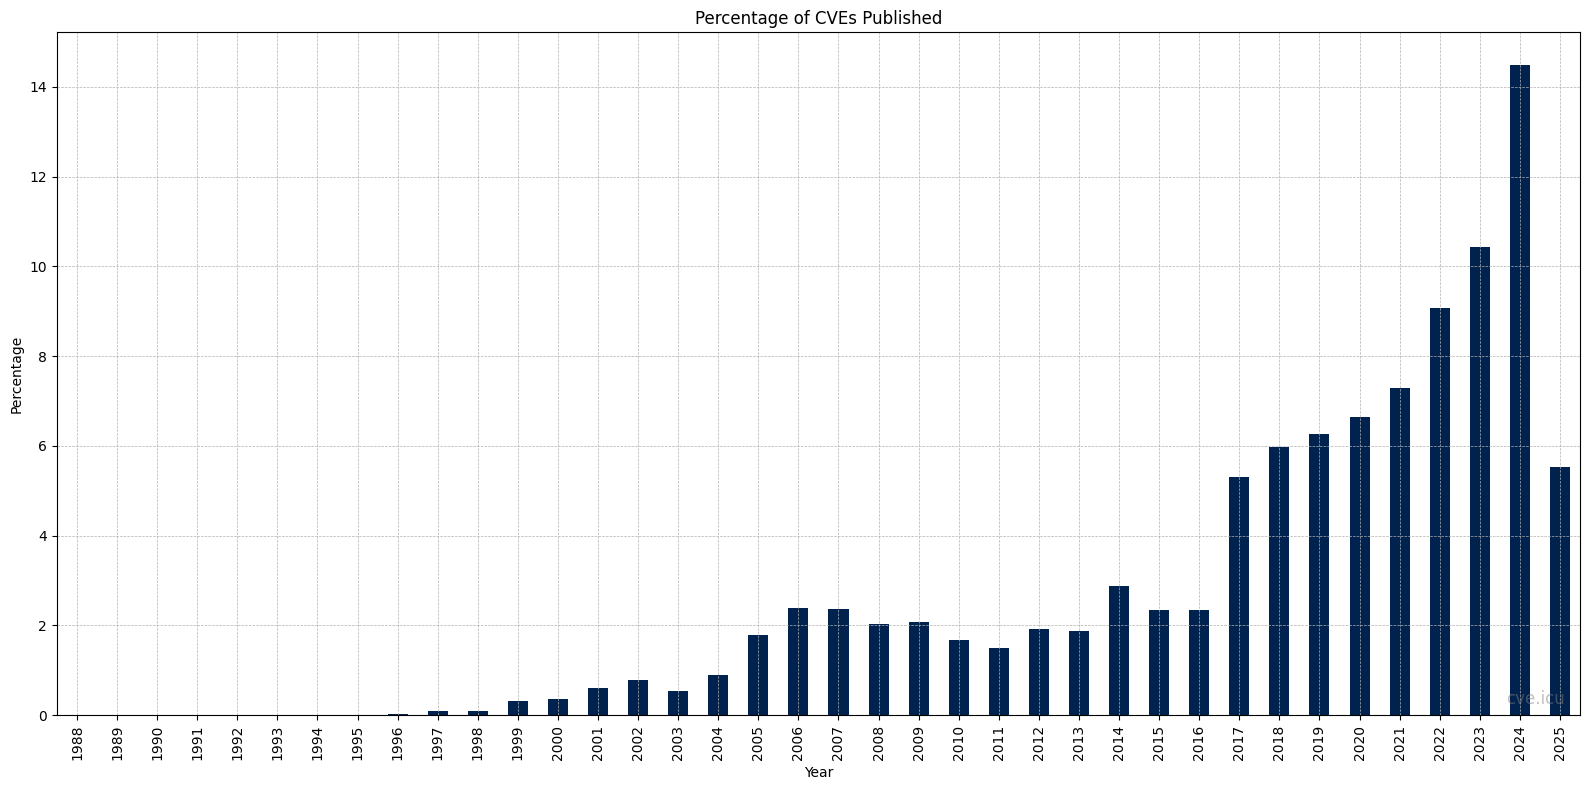

In [5]:
# Plot the graph
fig, ax = plt.subplots(figsize=(16, 8))
cg = yg_df.plot.bar(x='Published', y='Percentage Of CVEs', colormap='cividis', ax=ax, title='Percentage of CVEs Published', legend=False)
cg.set_ylabel("Percentage")
cg.set_xlabel("Year")
cg.grid(True, linestyle='--', linewidth=0.5)

# Add watermark
plt.text(0.99, 0.01, 'cve.icu', transform=cg.transAxes, fontsize=12, color='gray', alpha=0.5, ha='right', va='bottom')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
plt.close(fig) 

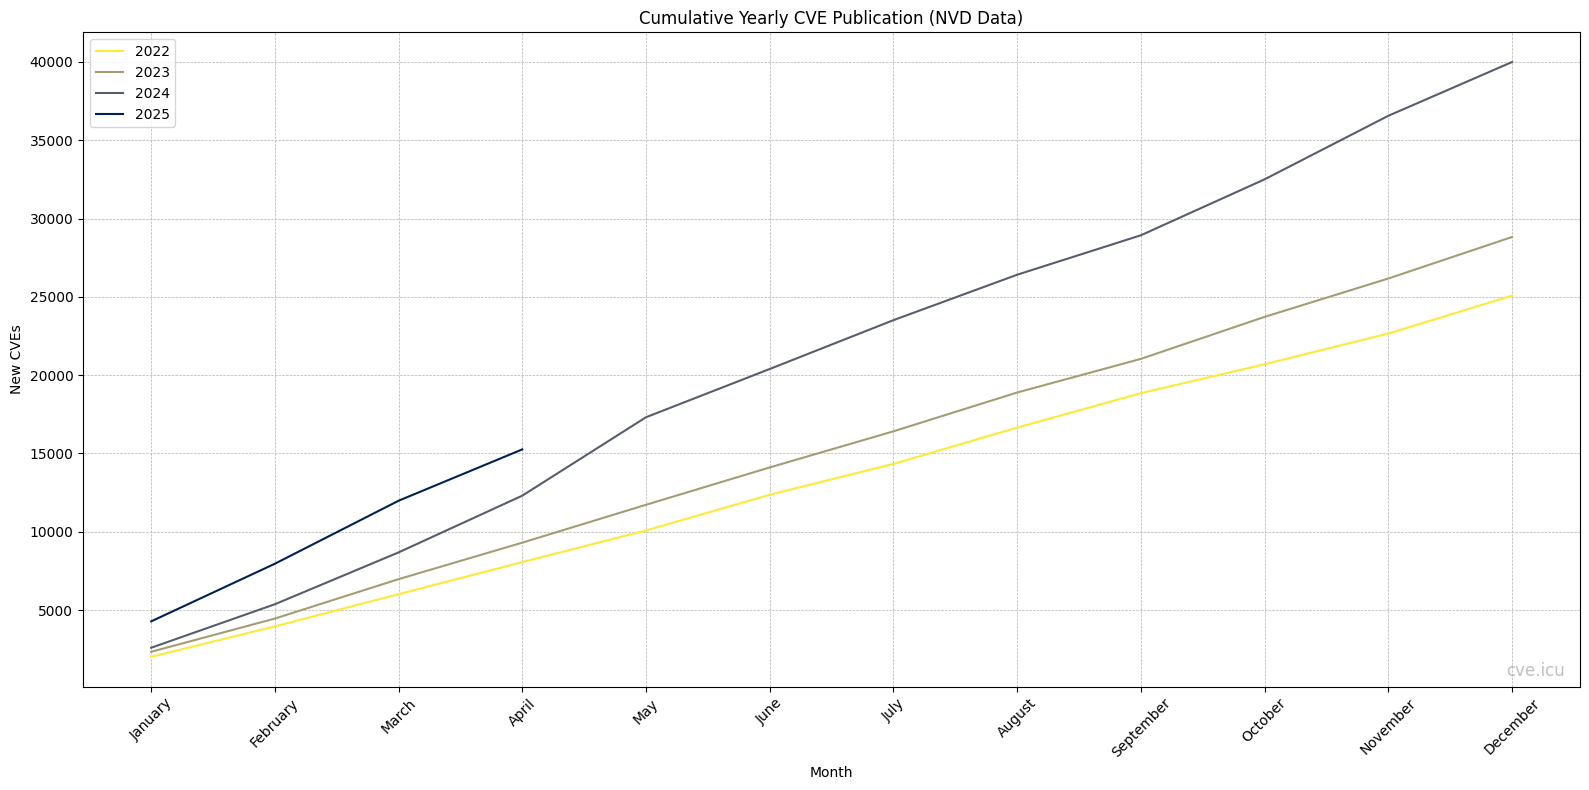

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by month and count the number of publications
Month_2020 = nvd_2020['Published'].groupby(nvd_2020.Published.dt.to_period("M")).agg('count')
Month_2021 = nvd_2021['Published'].groupby(nvd_2021.Published.dt.to_period("M")).agg('count')
Month_2022 = nvd_2022['Published'].groupby(nvd_2022.Published.dt.to_period("M")).agg('count')
Month_2023 = nvd_2023['Published'].groupby(nvd_2023.Published.dt.to_period("M")).agg('count')
Month_2024 = nvd_2024['Published'].groupby(nvd_2024.Published.dt.to_period("M")).agg('count')
Month_2025 = nvd_2025['Published'].groupby(nvd_2025.Published.dt.to_period("M")).agg('count')

# Reset index and rename columns
Month_2020 = Month_2020.reset_index(name="2020")
Month_2020 = Month_2020.rename(columns={"Published": "Month"}, errors="raise")
Month_2020['Month'] = Month_2020['Month'].dt.strftime('%B')

Month_2021 = Month_2021.reset_index(name="2021")
Month_2021 = Month_2021.rename(columns={"Published": "Month"}, errors="raise")
Month_2021['Month'] = Month_2021['Month'].dt.strftime('%B')

Month_2022 = Month_2022.reset_index(name="2022")
Month_2022 = Month_2022.rename(columns={"Published": "Month"}, errors="raise")
Month_2022['Month'] = Month_2022['Month'].dt.strftime('%B')

Month_2023 = Month_2023.reset_index(name="2023")
Month_2023 = Month_2023.rename(columns={"Published": "Month"}, errors="raise")
Month_2023['Month'] = Month_2023['Month'].dt.strftime('%B')

Month_2024 = Month_2024.reset_index(name="2024")
Month_2024 = Month_2024.rename(columns={"Published": "Month"}, errors="raise")
Month_2024['Month'] = Month_2024['Month'].dt.strftime('%B')

Month_2025 = Month_2025.reset_index(name="2025")
Month_2025 = Month_2025.rename(columns={"Published": "Month"}, errors="raise")
Month_2025['Month'] = Month_2025['Month'].dt.strftime('%B')

# Merge the dataframes
Months = pd.merge(Month_2022, Month_2023, how='left')
Months = pd.merge(Months, Month_2024, how='left')
Months = pd.merge(Months, Month_2025, how='left')

# Plot the cumulative sum
fig, ax = plt.subplots(figsize=(16, 8))
Months.cumsum().plot(ax=ax, title='Cumulative Yearly CVE Publication (NVD Data)', stacked=False, colormap='cividis_r')
ax.set_ylabel("New CVEs")
ax.set_xlabel("Month")
ax.grid(True, linestyle='--', linewidth=0.5)

# Customize the x-axis
x1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
squad = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
ax.set_xticks(x1)
ax.set_xticklabels(squad, minor=False, rotation=45)

# Add watermark
plt.text(0.99, 0.01, 'cve.icu', transform=ax.transAxes, fontsize=12, color='gray', alpha=0.5, ha='right', va='bottom')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
plt.close(fig)